In [24]:
%load_ext autoreload
%autoreload 2


from glob import glob
from itertools import chain, combinations
import math
import re

# import ensembl_rest
import numpy as np
import pandas as pd
from sourmash import load_signatures

import requests, sys
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import auc, roc_curve

import tqdm

from sklearn import metrics

import seaborn as sns

from khtools.ensembl import get_sequence, maybe_get_cds


from khtools.compare_peptide import compare_all_seqs
from khtools.homology import HomologyTable



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
orthologue_folder = '/mnt/ibm_lg/saba/orthologs/'


orthologues = pd.read_csv(f"{orthologue_folder}/human-mouse-orthologs/human-mouse-orthologs.txt.gz", compression='gzip', sep='\t')
# human_chimp = human_chimp.sort_values("Gene stable ID")
print(orthologues.shape)
orthologues.head()

homology_table = HomologyTable(orthologues, 'human', 'mouse')
homology_table

(162161, 20)


In [8]:
output_folder = '/home/olga/data_sm/kmer-hashing/orthologues/human-vs-mouse'
# non_coding_orthology = pd.read_csv(f"{output_folder}/non_coding_orthology_nsubset1000_seed0.csv")
# print(non_coding_orthology.shape)

# non_coding_orthology.head()

(1716000, 29)


,id1,id2,ksize,jaccard,molecule,species1,species2,species_species,Gene stable ID,Gene stable ID version,...,Last common ancestor with Mouse,Mouse homology type,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,Mouse Gene-order conservation score,Mouse Whole-genome alignment coverage,dN with Mouse,dS with Mouse,"Mouse orthology confidence [0 low, 1 high]",is_homologue
0,ENST00000364146,ENSMUST00000157136,2,1.000000,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,Eutheria,ortholog_one2many,69.4444,70.7547,No homology,No homology,No homology,No homology,0.0,True
1,ENST00000364146,ENSMUST00000157136,3,1.000000,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,Eutheria,ortholog_one2many,69.4444,70.7547,No homology,No homology,No homology,No homology,0.0,True
2,ENST00000364146,ENSMUST00000157136,4,1.000000,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,Eutheria,ortholog_one2many,69.4444,70.7547,No homology,No homology,No homology,No homology,0.0,True
3,ENST00000364146,ENSMUST00000157136,5,0.933333,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,Eutheria,ortholog_one2many,69.4444,70.7547,No homology,No homology,No homology,No homology,0.0,True
4,ENST00000364146,ENSMUST00000157136,6,0.836735,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,Eutheria,ortholog_one2many,69.4444,70.7547,No homology,No homology,No homology,No homology,0.0,True


In [ ]:
%%time

non_coding_orthology = homology_table.compare_orthology('non_coding', n_subset=3000, n_background=10)
print(non_coding_orthology.shape)
non_coding_orthology.head()

/home/olga/code/kmer-hashing/kh-tools/khtools/homology.py - 2019-09-17 05:28:21,544 INFO: datatype: non_coding, moltype: DNA, seqtype: cdna
/home/olga/code/kmer-hashing/kh-tools/khtools/homology.py - 2019-09-17 05:28:21,546 INFO: Subsetting data
/home/olga/code/kmer-hashing/kh-tools/khtools/homology.py - 2019-09-17 05:28:21,552 INFO: Getting sequences from IDs
  0%|          | 9/3000 [00:08<49:09,  1.01it/s]  

In [57]:
n_subset = 3000


In [56]:
non_coding_orthology.to_csv(f"{output_folder}/non_coding_orthology_nsubset{n_subset}_seed0.csv", index_col=0)


NameError: name 'n_subset' is not defined

In [39]:
orthology_categories = ['No homology', 'ortholog_many2many', 'ortholog_one2many', 'ortholog_one2one']

palette = dict(zip(orthology_categories, ['grey'] + sns.color_palette()))
palette

{'No homology': 'grey',
 'ortholog_many2many': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'ortholog_one2many': (1.0, 0.4980392156862745, 0.054901960784313725),
 'ortholog_one2one': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313)}

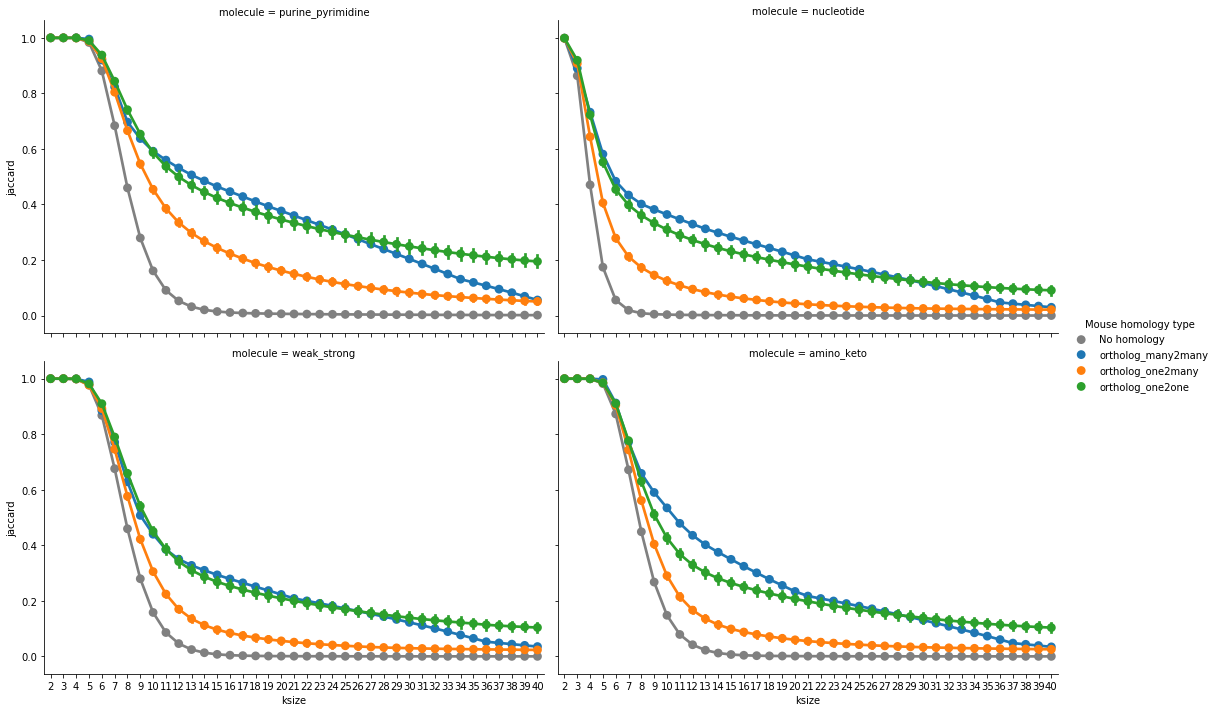

In [43]:
sns.catplot('ksize', 'jaccard', data=non_coding_orthology, col='molecule', col_wrap=2,
            hue=homology_table.homology_type_col, 
            kind='point', aspect=1.5, palette=palette, hue_order=orthology_categories)
# ax = plt.gca()
# ax.set(title='Non-coding RNA: Human vs Mouse')

In [45]:
def lookup(ensembl_id, verbose=False):
    server = "https://rest.ensembl.org"
    ext = f"/lookup/id/{ensembl_id}?expand=1"

    r = requests.get(server + ext,
                     headers={"Content-Type": "application/json"})

    if not r.ok:
        r.raise_for_status()
        sys.exit()

    decoded = r.json()
    # print(repr(decoded))
    if verbose:
        pprint(decoded)
    return decoded

def get_biotype(ensembl_id, verbose=False):
    lookup_result = lookup(ensembl_id, verbose)
    biotype = lookup_result['biotype']
    return biotype

In [46]:
id1s = non_coding_orthology.id1.unique()
id2s = non_coding_orthology.id2.unique()

In [47]:
len(id1s)

1785

In [48]:
len(id2s)

1665

In [49]:
all_ids = set(np.concatenate([id1s, id2s]))
len(all_ids)
# all_ids

3450

In [50]:
%%time
id_to_biotype = pd.Series({ensembl_id: get_biotype(ensembl_id) for ensembl_id in tqdm.tqdm(all_ids)})
print(id_to_biotype.shape)
id_to_biotype.head()

100%|██████████| 3450/3450 [1:12:37<00:00,  1.26s/it]

(3450,)
CPU times: user 1min 38s, sys: 15.5 s, total: 1min 54s
Wall time: 1h 12min 37s


In [51]:
id_to_biotype.head()

ENST00000362723         snoRNA
ENSMUST00000082576       snRNA
ENST00000614187       misc_RNA
ENST00000384614         snoRNA
ENSMUST00000104212      snoRNA
dtype: object

In [52]:
non_coding_orthology['id1_biotype'] = non_coding_orthology.id1.map(id_to_biotype)
non_coding_orthology['id2_biotype'] = non_coding_orthology.id2.map(id_to_biotype)
non_coding_orthology.head()

,id1,id2,ksize,jaccard,molecule,species1,species2,species_species,Gene stable ID,Gene stable ID version,...,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,Mouse Gene-order conservation score,Mouse Whole-genome alignment coverage,dN with Mouse,dS with Mouse,"Mouse orthology confidence [0 low, 1 high]",is_homologue,id1_biotype,id2_biotype
0,ENST00000364146,ENSMUST00000157136,2,1.000000,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,69.4444,70.7547,No homology,No homology,No homology,No homology,0,True,snRNA,snRNA
1,ENST00000364146,ENSMUST00000157136,3,1.000000,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,69.4444,70.7547,No homology,No homology,No homology,No homology,0,True,snRNA,snRNA
2,ENST00000364146,ENSMUST00000157136,4,1.000000,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,69.4444,70.7547,No homology,No homology,No homology,No homology,0,True,snRNA,snRNA
3,ENST00000364146,ENSMUST00000157136,5,0.933333,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,69.4444,70.7547,No homology,No homology,No homology,No homology,0,True,snRNA,snRNA
4,ENST00000364146,ENSMUST00000157136,6,0.836735,purine_pyrimidine,human,mouse,human_mouse,ENSG00000201016,ENSG00000201016.1,...,69.4444,70.7547,No homology,No homology,No homology,No homology,0,True,snRNA,snRNA


In [53]:
id1_biotypes = non_coding_orthology[['id1', 'id1_biotype']].drop_duplicates()
id1_biotypes.head()

,id1,id1_biotype
0,ENST00000364146,snRNA
1716,ENST00000459155,snoRNA
3432,ENST00000621512,misc_RNA
5148,ENST00000362224,miRNA
6864,ENST00000391224,snRNA


In [54]:
id1_biotypes.id1_biotype.value_counts()

snRNA       624
misc_RNA    466
snoRNA      420
miRNA       225
scaRNA       29
rRNA         16
ribozyme      4
sRNA          1
Name: id1_biotype, dtype: int64

miRNA (394680, 31)


ValueError: 'c' argument has 39 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

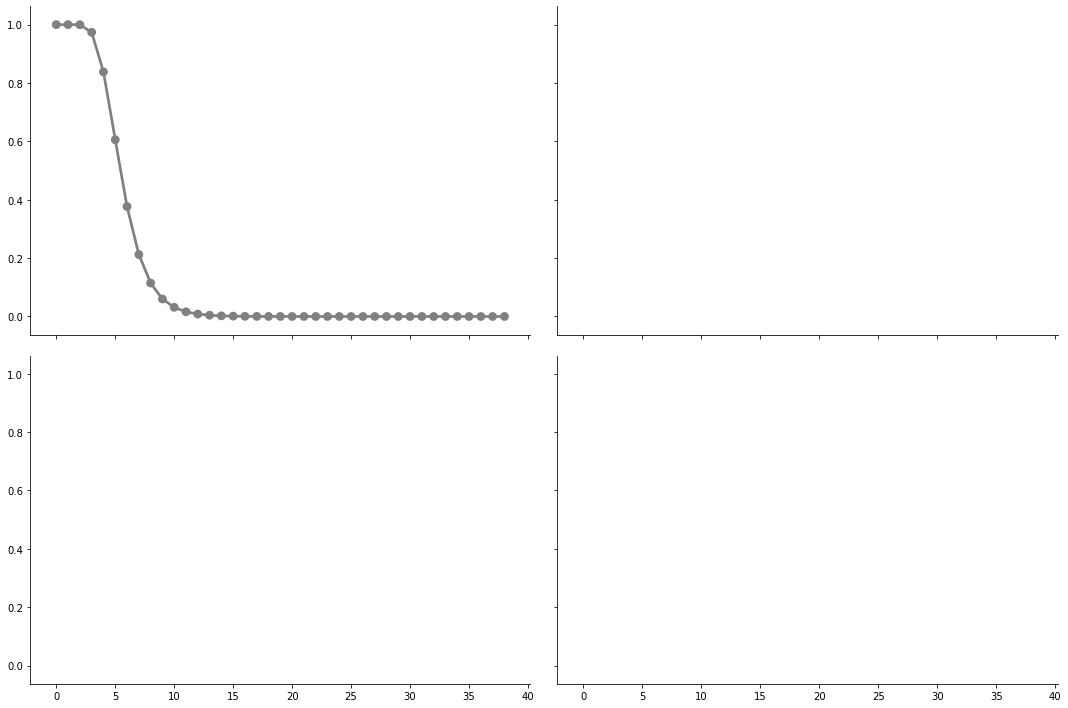

In [55]:
for biotype, df in non_coding_orthology.groupby('id1_biotype'):
    # Skip ribozyme as there are only 2
#     if biotype == 'ribozyme':
#         continue
    print(biotype, df.shape)
    
    
    sns.catplot('ksize', 'jaccard', data=df, col='molecule', col_wrap=2,
                hue=homology_table.homology_type_col, kind='point', aspect=1.5, palette=palette, hue_order=orthology_categories)
    fig = plt.gcf()
    fig.suptitle(f'Noncoding Biotype: {biotype}')
    
    
    sns.catplot('ksize', 'jaccard', data=df, hue='molecule', col_wrap=2,
                col=homology_table.homology_type_col, kind='point', aspect=1.5, palette='Set2')
    fig = plt.gcf()
    fig.suptitle(f'Noncoding Biotype: {biotype}')
